### "Socioeconomic and environmental determinants of COVID-19 in England" project notebook

This notebook contains all the data processing and analysis for this project.

#### Setting the working directory:

In [1]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)

Current Working Directory: c:\Users\klara\OneDrive\Skrivebord\covid_project


#### Importing libraries:

In [2]:
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd

#### Uploading datasets:

First the 'total deaths' dataset which I already collated in Excel. I did this using the three separate 'annual deaths local authority' datasets for 2020, 2021 and 2022. I then calculated the total deaths for each local authority across all three years. I also added to this dataset the total population per local authority from a different ONS dataset, based on a 2019 estimate. I decided to calculate a mortality rate per 10,000 based on the population per local authority and total deaths per local authority: total_deaths / population * 10000 = mortality per 10,000. This measure is not perfect as total deaths is calculated across several years, while the population statistic is a population estimate prior to COVID, but it does normalise the data in a way that takes into account regular differences in population size between different local authorities.

In [3]:
total_deaths_path = 'Covid deaths local authority/total_deaths.xlsx'
total_deaths = pd.read_excel(total_deaths_path)

total_deaths

,area_code,area_name,deaths2020,deaths2021,deaths2022,total_deaths,population,death_rate
0,E06000001,Hartlepool,191,127,45,363,93836,38.684513
1,E06000002,Middlesbrough,260,202,58,520,141285,36.805039
2,E06000003,Redcar and Cleveland,232,169,80,481,137228,35.051156
3,E06000004,Stockton-on-Tees,374,205,89,668,197419,33.836662
4,E06000005,Darlington,211,120,74,405,107402,37.708795
...,...,...,...,...,...,...,...,...
301,E09000029,Sutton,258,295,107,660,207707,31.775530
302,E09000030,Tower Hamlets,292,289,64,645,331969,19.429525
303,E09000031,Waltham Forest,368,302,119,789,276940,28.489926
304,E09000032,Wandsworth,293,286,123,702,329735,21.289824


Then the 'IMD' dataset which I have already filtered in Excel (based on the 'English Indices of Deprivation 2019' original dataset).
I filtered the original IMD file by creating a new Excel file containing only the variables I considered relevant.
I chose to focus on 'average scores' rather than any of the other measures included in the original IMD file.
I might not use all the variables included in this filtered IMD file for my final analysis, but I will include them for now.
I also added to this dataset the statistic 'people per km2', collected from ONS and representing the 2019 average.

In [4]:
IMD_path = 'IMD/IMD.xlsx'
IMD_df = pd.read_excel(IMD_path)

IMD_df

,area_code,area_name,avg_income_score,avg_employ_score,avg_est_score,avg_health_disability_score,avg_crime_score,avg_barriers_score,avg_environment_score,people_per_sq_km
0,E06000001,Hartlepool,0.228,0.185,30.255,0.869,0.566,14.242,6.943,985.5
1,E06000002,Middlesbrough,0.251,0.191,38.850,1.194,0.701,14.183,12.929,2671.2
2,E06000003,Redcar and Cleveland,0.186,0.165,27.768,0.790,0.138,14.139,7.793,557.1
3,E06000004,Stockton-on-Tees,0.164,0.135,24.786,0.684,-0.111,15.870,6.007,959.3
4,E06000005,Darlington,0.153,0.128,27.402,0.532,0.558,11.942,8.800,545.9
...,...,...,...,...,...,...,...,...,...,...
301,E09000029,Sutton,0.095,0.070,11.953,-0.570,-0.174,22.792,21.317,4781.0
302,E09000030,Tower Hamlets,0.192,0.100,16.934,0.195,0.509,30.491,33.213,15702.9
303,E09000031,Waltham Forest,0.152,0.093,16.968,-0.161,0.406,36.465,34.303,7173.3
304,E09000032,Wandsworth,0.107,0.064,6.649,-0.388,0.118,26.981,32.499,9560.0


Lastly the local authorities spatial dataset:

In [5]:
spatial_LA_path = '3393c1ec-7625-46ee-b5a4-370783173f4a202044-1-htedjg.l276p.shp'
spatial_LA = gpd.read_file(spatial_LA_path)

print(spatial_LA.columns)

Index(['FID', 'lad19cd', 'lad19nm', 'RAvgRank', 'RAvgScor', 'RPLMD10',
       'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


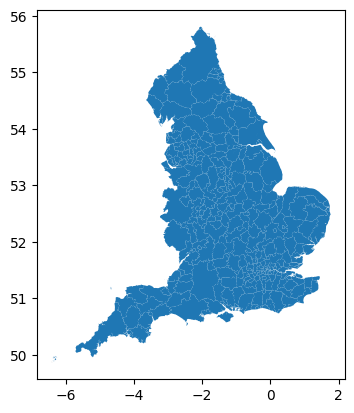

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Plot the GeoDataFrame
spatial_LA.plot()

# Show the plot
plt.show()

In [7]:
# Renaming some of the columns to match the other datasets 
spatial_LA = spatial_LA.rename(columns={'lad19cd': 'area_code'})

#### Merging the datasets
Next I will combine the datasets into one big dataset based on their shared 'area_code' column.

In [8]:
# Merge total_deaths with population
df = pd.merge(total_deaths, IMD_df, on='area_code', how='inner')

# Merge df with spatial_LA
df = pd.merge(df, spatial_LA, on='area_code', how='inner')

df

,area_code,area_name_x,deaths2020,deaths2021,deaths2022,total_deaths,population,death_rate,area_name_y,avg_income_score,...,avg_environment_score,people_per_sq_km,FID,lad19nm,RAvgRank,RAvgScor,RPLMD10,Shape__Are,Shape__Len,geometry
0,E06000001,Hartlepool,191,127,45,363,93836,38.684513,Hartlepool,0.228,...,6.943,985.5,1,Hartlepool,25,10,10,2.795747e+08,120551.653993,"MULTIPOLYGON (((-1.27025 54.72717, -1.26822 54..."
1,E06000002,Middlesbrough,260,202,58,520,141285,36.805039,Middlesbrough,0.251,...,12.929,2671.2,2,Middlesbrough,16,5,1,1.598560e+08,72792.845852,"MULTIPOLYGON (((-1.23003 54.58411, -1.23016 54..."
2,E06000003,Redcar and Cleveland,232,169,80,481,137228,35.051156,Redcar and Cleveland,0.186,...,7.793,557.1,3,Redcar and Cleveland,62,40,29,7.268747e+08,166333.283414,"MULTIPOLYGON (((-1.13749 54.64572, -1.13875 54..."
3,E06000004,Stockton-on-Tees,374,205,89,668,197419,33.836662,Stockton-on-Tees,0.164,...,6.007,959.3,4,Stockton-on-Tees,113,73,39,6.087106e+08,199133.016937,"MULTIPOLYGON (((-1.31776 54.64525, -1.31715 54..."
4,E06000005,Darlington,211,120,74,405,107402,37.708795,Darlington,0.153,...,8.800,545.9,7,Darlington,103,77,47,5.862003e+08,182217.151281,"POLYGON ((-1.43836 54.59508, -1.43807 54.59495..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E09000029,Sutton,258,295,107,660,207707,31.775530,Sutton,0.095,...,21.317,4781.0,315,Sutton,227,226,188,1.123168e+08,62543.635322,"POLYGON ((-0.13435 51.39089, -0.13261 51.39013..."
302,E09000030,Tower Hamlets,292,289,64,645,331969,19.429525,Tower Hamlets,0.192,...,33.213,15702.9,316,Tower Hamlets,27,50,175,5.101922e+07,43838.550428,"POLYGON ((-0.01654 51.54337, -0.01606 51.54254..."
303,E09000031,Waltham Forest,368,302,119,789,276940,28.489926,Waltham Forest,0.152,...,34.303,7173.3,317,Waltham Forest,45,82,162,1.004649e+08,52528.020854,"POLYGON ((0.02182 51.62883, 0.02099 51.62892, ..."
304,E09000032,Wandsworth,293,286,123,702,329735,21.289824,Wandsworth,0.107,...,32.499,9560.0,242,Wandsworth,173,183,195,8.817477e+07,60816.864731,"POLYGON ((-0.14038 51.41925, -0.14445 51.41775..."


I will clean this dataset a bit as it contains several irrrelevant columns:

In [9]:
# Dropping two of the area_name columns as they all contain the same info
df = df.drop(['area_name_y', 'FID', 'lad19nm', 'RAvgRank', 'RAvgScor',
              'RPLMD10', 'deaths2020', 'deaths2021', 'deaths2022', ], axis=1)

# Renaming the other area_name (x) column so it is just called 'area_name' again
df = df.rename(columns={'area_name_x': 'area_name'})

# Now the dataset looks like this:
df

,area_code,area_name,total_deaths,population,death_rate,avg_income_score,avg_employ_score,avg_est_score,avg_health_disability_score,avg_crime_score,avg_barriers_score,avg_environment_score,people_per_sq_km,Shape__Are,Shape__Len,geometry
0,E06000001,Hartlepool,363,93836,38.684513,0.228,0.185,30.255,0.869,0.566,14.242,6.943,985.5,2.795747e+08,120551.653993,"MULTIPOLYGON (((-1.27025 54.72717, -1.26822 54..."
1,E06000002,Middlesbrough,520,141285,36.805039,0.251,0.191,38.850,1.194,0.701,14.183,12.929,2671.2,1.598560e+08,72792.845852,"MULTIPOLYGON (((-1.23003 54.58411, -1.23016 54..."
2,E06000003,Redcar and Cleveland,481,137228,35.051156,0.186,0.165,27.768,0.790,0.138,14.139,7.793,557.1,7.268747e+08,166333.283414,"MULTIPOLYGON (((-1.13749 54.64572, -1.13875 54..."
3,E06000004,Stockton-on-Tees,668,197419,33.836662,0.164,0.135,24.786,0.684,-0.111,15.870,6.007,959.3,6.087106e+08,199133.016937,"MULTIPOLYGON (((-1.31776 54.64525, -1.31715 54..."
4,E06000005,Darlington,405,107402,37.708795,0.153,0.128,27.402,0.532,0.558,11.942,8.800,545.9,5.862003e+08,182217.151281,"POLYGON ((-1.43836 54.59508, -1.43807 54.59495..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E09000029,Sutton,660,207707,31.775530,0.095,0.070,11.953,-0.570,-0.174,22.792,21.317,4781.0,1.123168e+08,62543.635322,"POLYGON ((-0.13435 51.39089, -0.13261 51.39013..."
302,E09000030,Tower Hamlets,645,331969,19.429525,0.192,0.100,16.934,0.195,0.509,30.491,33.213,15702.9,5.101922e+07,43838.550428,"POLYGON ((-0.01654 51.54337, -0.01606 51.54254..."
303,E09000031,Waltham Forest,789,276940,28.489926,0.152,0.093,16.968,-0.161,0.406,36.465,34.303,7173.3,1.004649e+08,52528.020854,"POLYGON ((0.02182 51.62883, 0.02099 51.62892, ..."
304,E09000032,Wandsworth,702,329735,21.289824,0.107,0.064,6.649,-0.388,0.118,26.981,32.499,9560.0,8.817477e+07,60816.864731,"POLYGON ((-0.14038 51.41925, -0.14445 51.41775..."


#### Some preliminary data analysis
I will start with the basics of my dataset, that is, min., max., mean, etc.

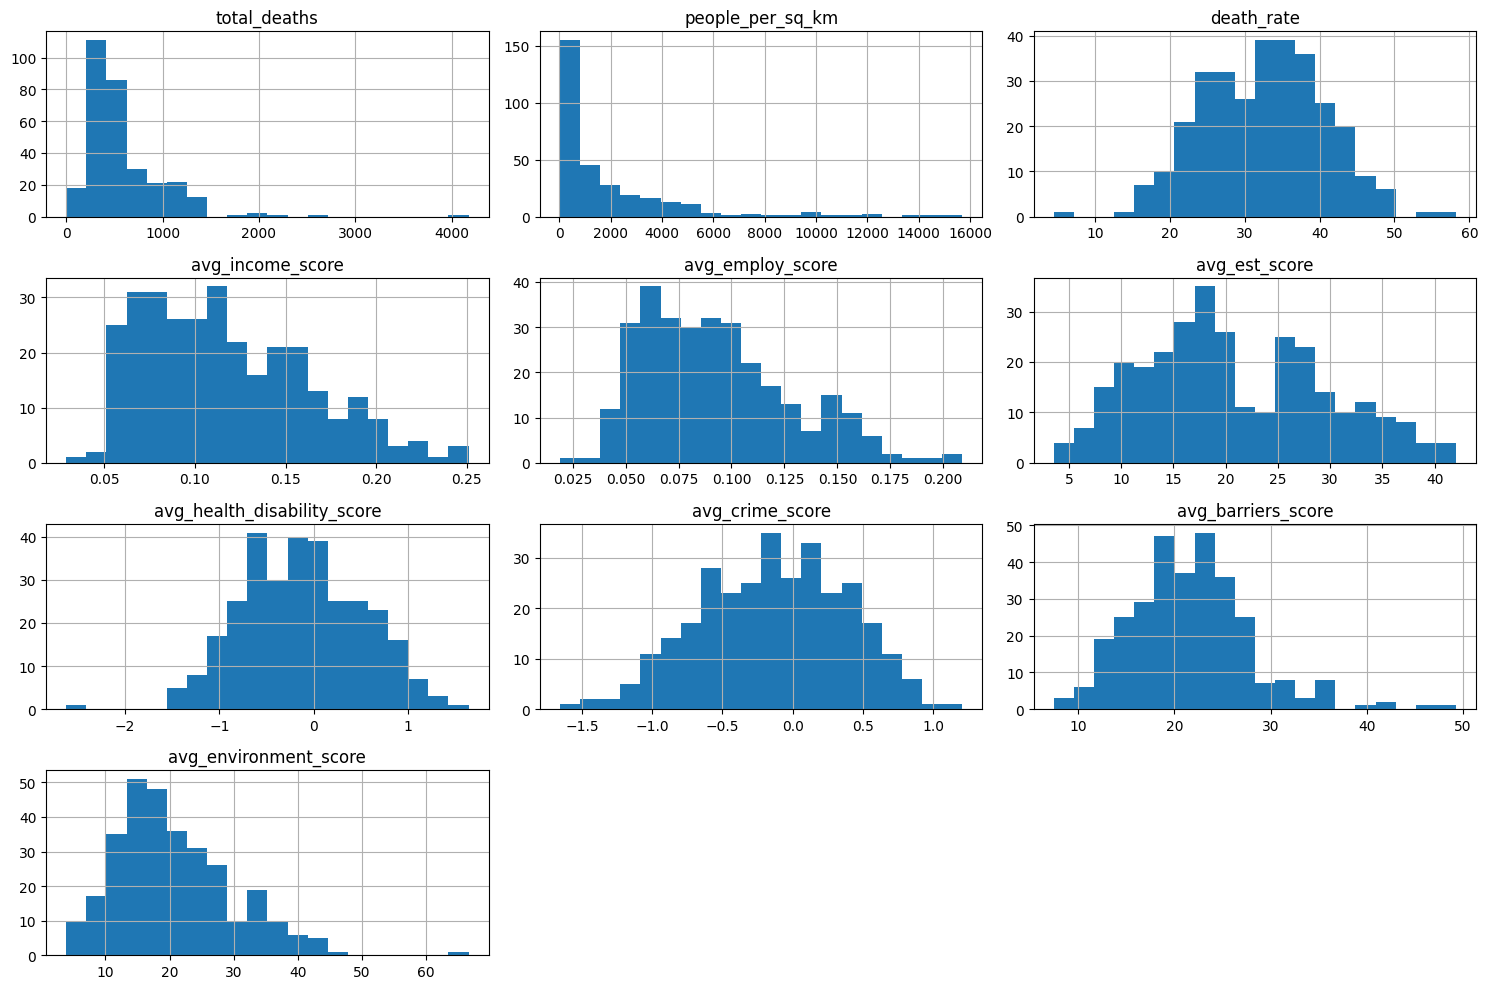

Areas with highest scores:
total_deaths: E08000025 - Birmingham - 4174
people_per_sq_km: E09000030 - Tower Hamlets - 15702.9
death_rate: E07000076 - Tendring - 58.227521665660014
avg_income_score: E06000002 - Middlesbrough - 0.251
avg_employ_score: E06000009 - Blackpool - 0.209
avg_est_score: E07000136 - Boston - 42.053
avg_health_disability_score: E06000009 - Blackpool - 1.643
avg_crime_score: E08000003 - Manchester - 1.206
avg_barriers_score: E09000025 - Newham - 49.306
avg_environment_score: E06000053 - Isles of Scilly - 66.667

Areas with lowest scores:
total_deaths: E06000053 - Isles of Scilly - 1
people_per_sq_km: E07000030 - Eden - 25.5
death_rate: E06000053 - Isles of Scilly - 4.492362982929021
avg_income_score: E06000053 - Isles of Scilly - 0.029
avg_employ_score: E06000053 - Isles of Scilly - 0.019
avg_est_score: E09000027 - Richmond upon Thames - 3.534
avg_health_disability_score: E06000053 - Isles of Scilly - -2.625
avg_crime_score: E09000001 - City of London - -1.656
avg_b

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Descriptive statistics for selected columns
selected_columns = ['total_deaths', 'people_per_sq_km', 'death_rate', 'avg_income_score', 
                    'avg_employ_score', 'avg_est_score', 'avg_health_disability_score', 
                    'avg_crime_score', 'avg_barriers_score', 'avg_environment_score']
desc_stats = df[selected_columns].describe()

# Areas with highest and lowest scores for each variable
highest_scores = desc_stats.loc['max']
lowest_scores = desc_stats.loc['min']

# Plot histograms
df[selected_columns].hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

# Print areas with highest scores
print("Areas with highest scores:")
for col in selected_columns:
    max_score_index = df[col].idxmax()
    max_score_area = df.loc[max_score_index, ['area_code', 'area_name', col]]
    print(f"{col}: {max_score_area.iloc[0]} - {max_score_area.iloc[1]} - {max_score_area.iloc[2]}")

print("\nAreas with lowest scores:")
for col in selected_columns:
    min_score_index = df[col].idxmin()
    min_score_area = df.loc[min_score_index, ['area_code', 'area_name', col]]
    print(f"{col}: {min_score_area.iloc[0]} - {min_score_area.iloc[1]} - {min_score_area.iloc[2]}")

#### Correlation between variables of interest
I test in the most simple way the correlation between variables in my dataset and 'death_rate'. 
There is nothing very noticeable correlation wise, at least between total deaths and other variables: 
* Average employment deprivation score has the strongest (but still moderate at 0.48) correlation with death rate: it is a positive correlation indicating that when employment deprivation increases, number of deaths increase.
* This is followed by a moderate positive correlation between average education, skills and training (EST) deprivation score and death rate (at 0.47), indicating that where EST deprivation is more prevalent, COVID deaths have also been more prevalent.
* Then a moderate positive correlation between average health deprivation and disability score and death rate (at 0.44), indicating that where health deprivation is greater, COVID deaths have also been more prevalent.

Importantly though, several of the other variables have strong positive correlations:
* average income deprivation score + average employment deprivation score = 0.94
* average income deprivation score + average health deprivation and disability score = 0.87
* average employment deprivation score + average health deprivation and disability score = 0.92
* average education, skills and training score + average health deprivation and disability score = 0.81

This is important for multiple linear regression where including these strongly correlated variables might reduce model precision through multicollinearity.

In [19]:
# Specify the variables to compute correlations for
correlation_variables = ['death_rate', 'people_per_sq_km', 'avg_income_score', 'avg_employ_score', 
                        'avg_est_score', 'avg_health_disability_score', 'avg_crime_score', 
                        'avg_barriers_score', 'avg_environment_score']

# Compute the correlation matrix
correlation_matrix = df[correlation_variables].corr()

# Print the correlation matrix
correlation_matrix


,death_rate,people_per_sq_km,avg_income_score,avg_employ_score,avg_est_score,avg_health_disability_score,avg_crime_score,avg_barriers_score,avg_environment_score
death_rate,1.000000,-0.206128,0.357355,0.483317,0.465710,0.443963,0.242264,-0.375002,-0.211036
people_per_sq_km,-0.206128,1.000000,0.405687,0.159280,-0.080573,0.147801,0.500293,0.413493,0.423475
avg_income_score,0.357355,0.405687,1.000000,0.943906,0.748224,0.873585,0.724004,-0.144240,0.303660
avg_employ_score,0.483317,0.159280,0.943906,1.000000,0.802862,0.923538,0.593913,-0.350537,0.188424
avg_est_score,0.465710,-0.080573,0.748224,0.802862,1.000000,0.806457,0.482402,-0.327056,0.043781
avg_health_disability_score,0.443963,0.147801,0.873585,0.923538,0.806457,1.000000,0.566999,-0.369097,0.166137
avg_crime_score,0.242264,0.500293,0.724004,0.593913,0.482402,0.566999,1.000000,-0.050768,0.173267
avg_barriers_score,-0.375002,0.413493,-0.144240,-0.350537,-0.327056,-0.369097,-0.050768,1.000000,0.198619
avg_environment_score,-0.211036,0.423475,0.303660,0.188424,0.043781,0.166137,0.173267,0.198619,1.000000


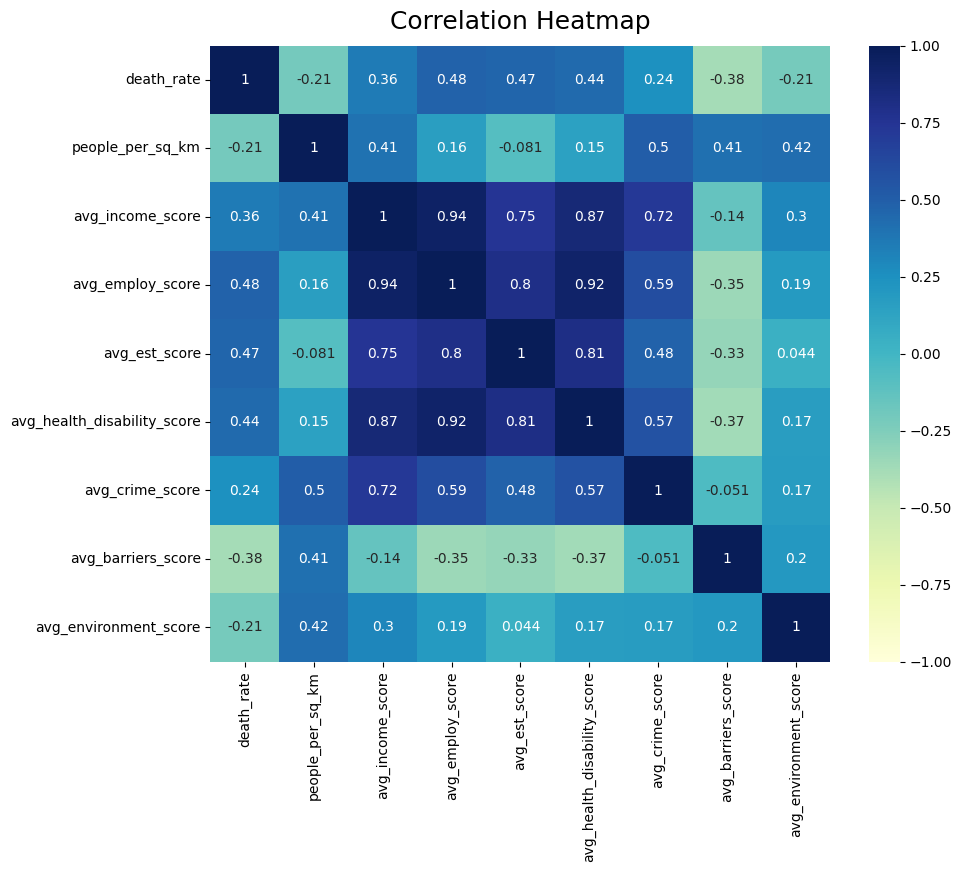

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df[correlation_variables].corr(), vmin=-1, vmax=1, annot=True, cmap='YlGnBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

#### OLS

I start with three simple linear regression models focusing on each of the (independent) variables 'average employment deprivation score', 'average health deprivation and disability score', and 'average living environment deprivation score'.
* As per the R2 statistic, employment deprivation seemingly has the greatest explanatory power for variation in the dependent variable, 'death_rate', at 0.23 (p < 0.05>), though this is still not a particularly high R2 value. 
* The health deprivation R2 = 0.20 (p < 0.05), meaning that it explains ~20% of variability of COVID death rate.
* The living environment deprivation has a very small R2 value at 0.05 (p < 0.05), meaning that this variable only explains ~ 5% of variability of COVID death rate. Further, living environment is interestingly negatively correlated with COVID mortality rate, meaning that where living environment deprivation is more prevalent, COVID mortality rate has been not been as high (albeit the correlation is weak).   

                            OLS Regression Results                            
Dep. Variable:             death_rate   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     92.66
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           2.56e-19
Time:                        15:05:09   Log-Likelihood:                -1032.5
No. Observations:                 306   AIC:                             2069.
Df Residuals:                     304   BIC:                             2077.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               22.1469      1.155  

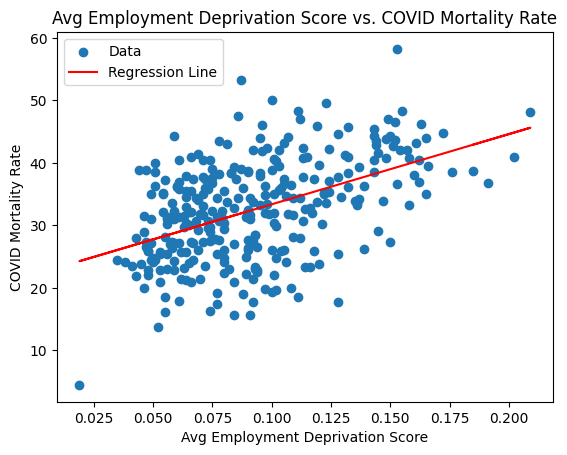

In [17]:
import statsmodels.api as sm

# Add a constant to the predictor variable
X = sm.add_constant(df['avg_employ_score'])
y = df['death_rate']

# Fit the model
model = sm.OLS(y, X, missing='drop').fit()  # 'missing='drop'' tells the model to ignore any NaN values

# Print the summary of the model
print(model.summary())

# Scatter plot
plt.scatter(df['avg_employ_score'], df['death_rate'], label='Data')

# Regression line
# We get the predicted values using the model we've already fit
predicted_values = model.predict(sm.add_constant(df['avg_employ_score']))

# Plotting the regression line
plt.plot(df['avg_employ_score'], predicted_values, color='red', label='Regression Line')

# Adding labels and title
plt.xlabel('Avg Employment Deprivation Score')
plt.ylabel('COVID Mortality Rate')
plt.title('Avg Employment Deprivation Score vs. COVID Mortality Rate')
plt.legend()

# Show plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:             death_rate   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     74.63
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           3.28e-16
Time:                        15:06:30   Log-Likelihood:                -1039.7
No. Observations:                 306   AIC:                             2083.
Df Residuals:                     304   BIC:                             2091.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

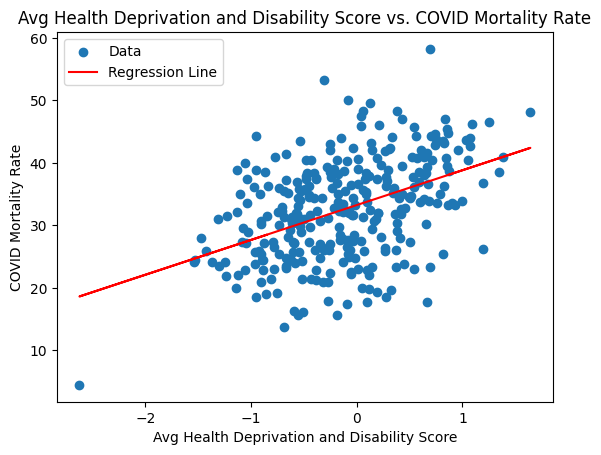

In [18]:
import statsmodels.api as sm

# Add a constant to the predictor variable
X = sm.add_constant(df['avg_health_disability_score'])
y = df['death_rate']

# Fit the model
model = sm.OLS(y, X, missing='drop').fit()  # 'missing='drop'' tells the model to ignore any NaN values

# Print the summary of the model
print(model.summary())

# Scatter plot
plt.scatter(df['avg_health_disability_score'], df['death_rate'], label='Data')

# Regression line
# We get the predicted values using the model we've already fit
predicted_values = model.predict(sm.add_constant(df['avg_health_disability_score']))

# Plotting the regression line
plt.plot(df['avg_health_disability_score'], predicted_values, color='red', label='Regression Line')

# Adding labels and title
plt.xlabel('Avg Health Deprivation and Disability Score')
plt.ylabel('COVID Mortality Rate')
plt.title('Avg Health Deprivation and Disability Score vs. COVID Mortality Rate')
plt.legend()

# Show plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:             death_rate   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     14.17
Date:                Thu, 04 Apr 2024   Prob (F-statistic):           0.000200
Time:                        15:07:34   Log-Likelihood:                -1066.3
No. Observations:                 306   AIC:                             2137.
Df Residuals:                     304   BIC:                             2144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    36.44

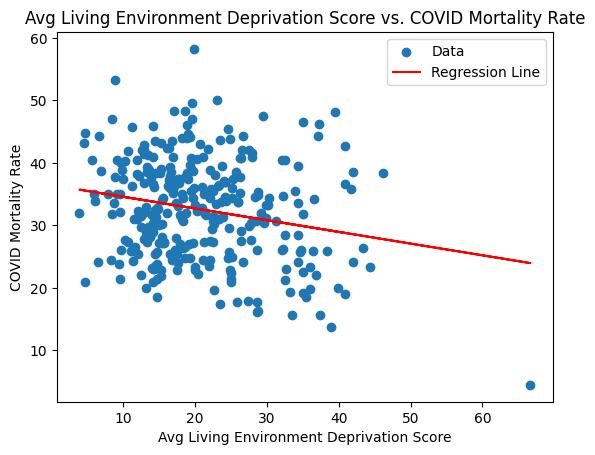

In [19]:
import statsmodels.api as sm

# Add a constant to the predictor variable
X = sm.add_constant(df['avg_environment_score'])
y = df['death_rate']

# Fit the model
model = sm.OLS(y, X, missing='drop').fit()  # 'missing='drop'' tells the model to ignore any NaN values

# Print the summary of the model
print(model.summary())

# Scatter plot
plt.scatter(df['avg_environment_score'], df['death_rate'], label='Data')

# Regression line
# We get the predicted values using the model we've already fit
predicted_values = model.predict(sm.add_constant(df['avg_environment_score']))

# Plotting the regression line
plt.plot(df['avg_environment_score'], predicted_values, color='red', label='Regression Line')

# Adding labels and title
plt.xlabel('Avg Living Environment Deprivation Score')
plt.ylabel('COVID Mortality Rate')
plt.title('Avg Living Environment Deprivation Score vs. COVID Mortality Rate')
plt.legend()

# Show plot
plt.show()

#### OLS Multiple Regression
I now perform a multiple linear regression (MLR), which is similar to the regression models above, but looks at the explanatory power of each independent variable included while holding all other variables constant. Adjusted r-squared is the r-squared value that should be noted for MLR because it is adjusted to reflect the addition of independent variables that increase r-squared but do not make a significant contribution to model fit.

The initial model fit (adj. R2 = 0.37) is greater than it was for any individual variables above. However, I'm aware that a number of my independent variables are strongly correlated and the multicollinearity might be impacting variable coefficients. 

In [20]:
import pysal.lib
import pysal.model

dependent_name = ['death_rate']

independent_names = ['avg_income_score', 'avg_health_disability_score', 'people_per_sq_km', 
                     'avg_environment_score', 'avg_employ_score', 'avg_est_score', 'avg_crime_score', 
                    'avg_barriers_score']

model_data = df[dependent_name + independent_names + ['geometry']]

model_data = model_data.dropna()

ols_model_1 = pysal.model.spreg.OLS(model_data[dependent_name].values,
        model_data[independent_names].values,
        name_y = dependent_name, name_x = independent_names)

print(ols_model_1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :['death_rate']                Number of Observations:         306
Mean dependent var  :     32.5586                Number of Variables   :           9
S.D. dependent var  :      8.0853                Degrees of Freedom    :         297
R-squared           :      0.3888
Adjusted R-squared  :      0.3723
Sum squared residual:     12186.8                F-statistic           :     23.6145
Sigma-square        :      41.033                Prob(F-statistic)     :   6.128e-28
S.E. of regression  :       6.406                Log likelihood        :    -997.927
Sigma-square ML     :      39.826                Akaike info criterion :    2013.854
S.E of regression ML:      6.3108                Schwarz criterion     :    2047.366

----------------------------------------------------------

I want to identify and remove the most significantly correlated independent variables. I use Variance inflation factor (VIF), which is a value that can be used to identify independent variables that are correlated with each other.

The VIF values for each independent variable are listed in the same order as the OLS model summary() above:

In [21]:
pysal.model.spreg.vif(ols_model_1)

[None,
 (40.964763966289766, 0.02441122328503853),
 (7.810154966515182, 0.1280384325646986),
 (3.7977812942616684, 0.26331163448273587),
 (1.3447595023231709, 0.7436273908252193),
 (34.509042331578144, 0.0289779122350472),
 (4.313393323747838, 0.23183603370793837),
 (2.841068324934659, 0.35198027137309296),
 (1.9893068228219886, 0.5026876641288653)]

To reduce multicollinearity, I need to remove some of the variables with the highest VIF until all VIF values are at least below 5 and, preferably below 2.5. Employment deprivation is strongly correlated with at least three other independent variables in my model: however, it is also the independent variable that has the strongest correlation with COVID mortality rate. So to start with, I create an MLR model that includes employment deprivation score by combining it with independent variables that it has weak correleation with:

The MLR model includes the following independent variables:
- Average employment deprivation score
- People per km2
- Average living environment deprivation score
- Average crime score
- Average barriers to housing and services score

The model fit (adj. R2) = 0.36, means that the model explains ~36% of the variability of the dependent variable, COVID mortality rate, which is quite an improvement on the simple linear regression models above, while also accounting for multicollinearity. Not all independent variables in this model have statistically significant relationships with the dependent variable, however.


In [34]:
dependent_name = ['death_rate']

independent_names = ['people_per_sq_km', 'avg_environment_score', 'avg_employ_score', 
                     'avg_crime_score', 'avg_barriers_score']

model_data = df[dependent_name + independent_names + ['geometry']]

model_data = model_data.dropna()

ols_model_2 = pysal.model.spreg.OLS(model_data[dependent_name].values,
        model_data[independent_names].values,
        name_y = dependent_name, name_x = independent_names)

print(ols_model_2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :['death_rate']                Number of Observations:         306
Mean dependent var  :     32.5586                Number of Variables   :           6
S.D. dependent var  :      8.0853                Degrees of Freedom    :         300
R-squared           :      0.3685
Adjusted R-squared  :      0.3580
Sum squared residual:       12591                F-statistic           :     35.0132
Sigma-square        :      41.970                Prob(F-statistic)     :   3.614e-28
S.E. of regression  :       6.478                Log likelihood        :   -1002.920
Sigma-square ML     :      41.147                Akaike info criterion :    2017.839
S.E of regression ML:      6.4146                Schwarz criterion     :    2040.181

----------------------------------------------------------

In [35]:
# Prints VIF scores which I want to keep < 2.5 
pysal.model.spreg.vif(ols_model_2)

[None,
 (2.0454775101978746, 0.48888340009334175),
 (1.2873594162942545, 0.7767838471081862),
 (1.9358490686704835, 0.5165691975598011),
 (2.154597505401488, 0.4641238085039274),
 (1.5567266144445215, 0.6423735489078309)]

As the independent variables 'health deprivation and disability', 'employment deprivation', 'income_deprivation', and 'EST deprivation' all have strong positive correlations, I cannot include them in the same model, but I wish to make an MLR model including health deprivation also. This model includes all the same variables as above, but 'employment deprivation' is replaced by 'health deprivation and disability':

- Average health deprivation and disability score
- People per km2
- Average living environment deprivation score
- Average crime score
- Average barriers to housing and services score

The model fit (adj. R2) = 0.32, meaning that the model explains ~32% of the variability of the dependent variable, COVID mortality rate. Again, not all independent variables have a statistically significant relationship with the dependent variable. The model fit is seemingly not as good as the one above including employment deprivation.

In [45]:
dependent_name = ['death_rate']

independent_names = ['avg_health_disability_score', 'people_per_sq_km', 
                     'avg_environment_score', 'avg_crime_score', 
                    'avg_barriers_score']

model_data = df[dependent_name + independent_names + ['geometry']]

model_data = model_data.dropna()

ols_model_3 = pysal.model.spreg.OLS(model_data[dependent_name].values,
        model_data[independent_names].values,
        name_y = dependent_name, name_x = independent_names)

print(ols_model_3.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :['death_rate']                Number of Observations:         306
Mean dependent var  :     32.5586                Number of Variables   :           6
S.D. dependent var  :      8.0853                Degrees of Freedom    :         300
R-squared           :      0.3311
Adjusted R-squared  :      0.3199
Sum squared residual:     13337.3                F-statistic           :     29.6968
Sigma-square        :      44.458                Prob(F-statistic)     :    1.74e-24
S.E. of regression  :       6.668                Log likelihood        :   -1011.729
Sigma-square ML     :      43.586                Akaike info criterion :    2035.459
S.E of regression ML:      6.6020                Schwarz criterion     :    2057.800

----------------------------------------------------------

In [46]:
# Prints VIF scores which I want to keep < 2.5 
pysal.model.spreg.vif(ols_model_3)

[None,
 (1.8498202086770146, 0.5405930778079221),
 (2.038402361325946, 0.49058027942506743),
 (1.270187096714328, 0.7872855916949261),
 (2.043851599718895, 0.48927231318435094),
 (1.583040644016899, 0.6316957203717412)]